In [1]:
import torch
import sys
import os.path as osp
import os
import sys
import numpy as np

sys.path.append("/afs/cern.ch/work/m/mgarciam/private/Tracking_wcoc/")
from src.dataset.dataset import SimpleIterDataset
from src.utils.train_utils import to_filelist
from torch.utils.data import DataLoader
#import dgl  # CPU only version for now
from tqdm import tqdm
from torch_scatter import scatter_sum
import matplotlib.pyplot as plt
import pickle
import numpy as np
import mplhep as hep


hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=13)


/afs/cern.ch/work/m/mgarciam/private/miniconda/miniconda3/envs/graphgps0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dic_background = np.load("/afs/cern.ch/work/m/mgarciam/private/Tracking_wcoc/data_creation/condor_background_IDEA/test_scripts/bkg_background_particles_500_v8_2.npy", allow_pickle=True).item()
dic_signal = np.load("/afs/cern.ch/work/m/mgarciam/private/Tracking_wcoc/data_creation/condor_background_IDEA/test_scripts/signal_background_particles_500_v8_2.npy", allow_pickle=True).item()

In [3]:
dic_MC = np.load("/afs/cern.ch/work/m/mgarciam/private/Tracking_wcoc/data_creation/condor_background_IDEA/test_scripts/background_particles_IDEA_o1_v03_v8_v1.npy", allow_pickle=True).item()

In [19]:
np.array(dic_signal["count_hits"]).shape


(27219,)

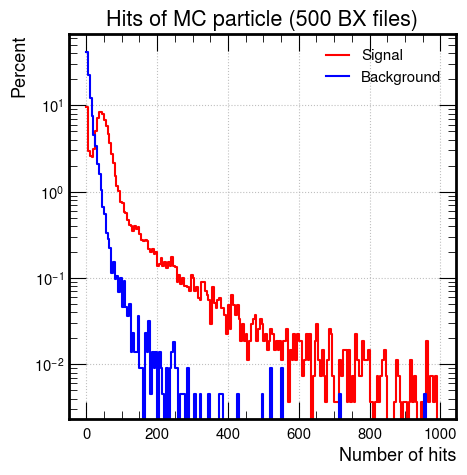

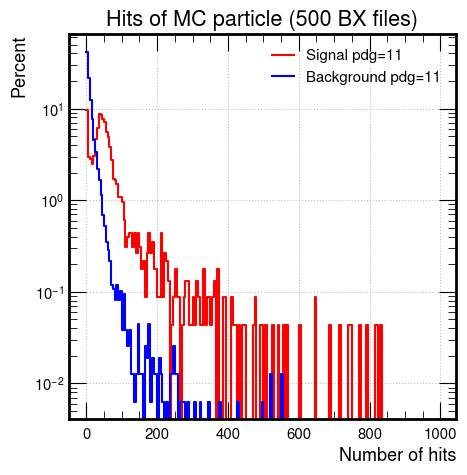

In [21]:
import seaborn as sns
# bins = np.exp(np.arange(np.log(0.00001), np.log(150), 0.3))
bins = np.arange(0, 1000, 5)
plt.figure(figsize=(5,5))
signal = np.array(dic_signal["count_hits"])
# signal_v1 = np.array(dic_signal["pt"][dic_signal["count_hits"]>50])
background = np.array(dic_background["count_hits"])
sns.histplot(signal, stat="percent", element="step", fill=False, bins=bins, color="red", label="Signal")
sns.histplot(background, stat="percent", element="step", fill=False, bins=bins, color="blue", label="Background")
# plt.xscale("log")
plt.xlabel("Number of hits")
plt.title("Hits of MC particle (500 BX files)")
plt.yscale("log")
plt.grid()
plt.legend()


bins = np.arange(0, 1000, 5)
plt.figure(figsize=(5,5))
mask = np.abs(np.array([dic_signal["pdg"]]))==11
signal = np.array(dic_signal["count_hits"])[mask[0,:]]
mask = np.abs(np.array([dic_background["pdg"]]))==11
background = np.array(dic_background["count_hits"])[mask[0,:]]
sns.histplot(signal, stat="percent", element="step", fill=False, bins=bins, color="red", label="Signal pdg=11")
sns.histplot(background, stat="percent", element="step", fill=False, bins=bins, color="blue", label="Background pdg=11")
# plt.xscale("log")
plt.xlabel("Number of hits")
plt.title("Hits of MC particle (500 BX files)")
plt.yscale("log")
plt.grid()
plt.legend()

Text(0.5, 1.0, 'Number of hits vs $p_T$ signal')

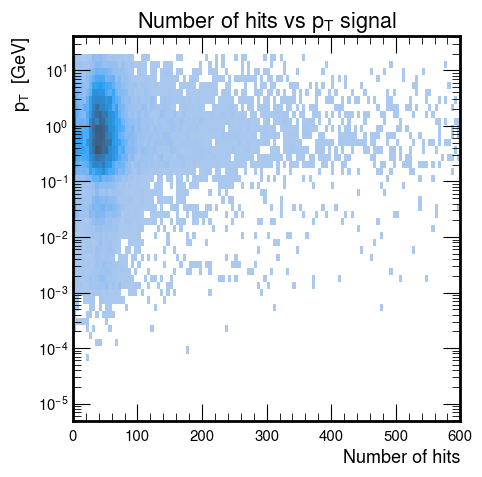

In [41]:
plt.figure(figsize=(5,5))
bins_x =  np.arange(0, 1000, 5)
bins_y = np.geomspace(0.00001, 20, num=50) #np.exp(np.arange(np.log(0.00001), np.log(150), 0.3))
sns.histplot( x=np.array(dic_signal["count_hits"]), y=np.array(dic_signal["pt"]), bins=(bins_x, bins_y))
plt.xlim(0,600)
# plt.ylim(0,1)
plt.yscale("log")
plt.xlabel("Number of hits")
plt.ylabel("$p_T$  [GeV]")
plt.title("Number of hits vs $p_T$ signal")

Text(0.5, 1.0, 'Number of hits vs $p_T$ background')

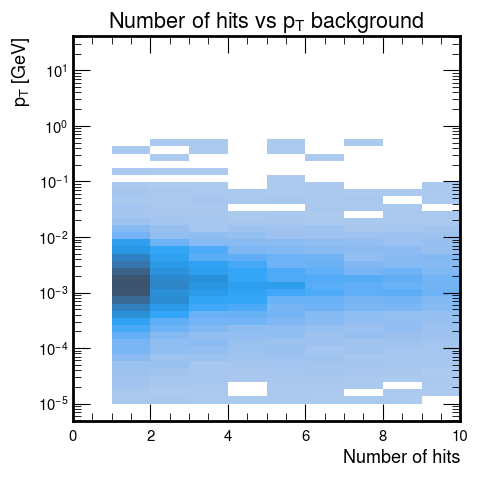

In [44]:
plt.figure(figsize=(5,5))
bins_x =  np.arange(0, 200, 1)
bins_y = np.geomspace(0.00001, 20, num=50) #np.exp(np.arange(np.log(0.00001), np.log(150), 0.3))
sns.histplot( x=np.array(dic_background["count_hits"]), y=np.array(dic_background["pt"]), bins=(bins_x, bins_y))
plt.xlim(0,10)
# plt.ylim(0,1)
plt.yscale("log")
plt.xlabel("Number of hits")
plt.ylabel("$p_T$ [GeV]")
plt.title("Number of hits vs $p_T$ background")

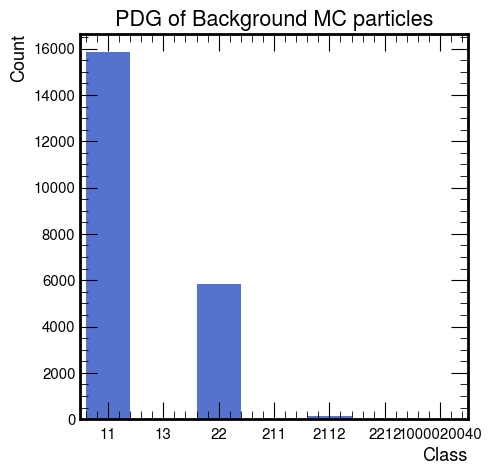

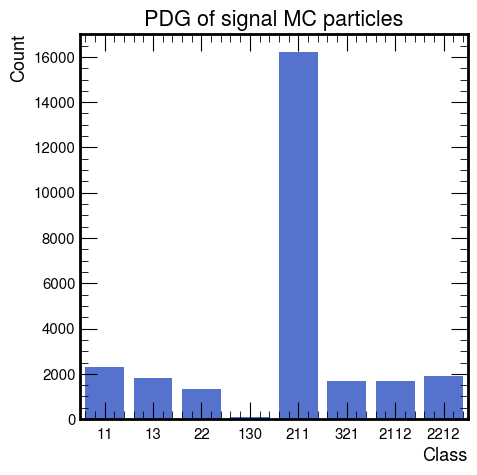

In [60]:
pdg = np.abs(dic_background["pdg"])
# Find unique classes
unique_classes, counts = np.unique(pdg, return_counts=True)

# Plot histogram
plt.figure(figsize=(5, 5))
sns.barplot(x=unique_classes, y=counts, color="royalblue")

# Labels
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("PDG of Background MC particles")

# Show plot
plt.show()


pdg = np.abs(dic_signal["pdg"])
# Find unique classes
unique_classes, counts = np.unique(pdg, return_counts=True)
mask = counts>70
# Plot histogram
plt.figure(figsize=(5, 5))
sns.barplot(x=unique_classes[mask], y=counts[mask], color="royalblue")
# Labels
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("PDG of signal MC particles")

# Show plot
plt.show()



In [59]:
counts[mask]

array([ 2294,  1825,  1349,    89, 16196,  1700,  1673,  1926,    64])

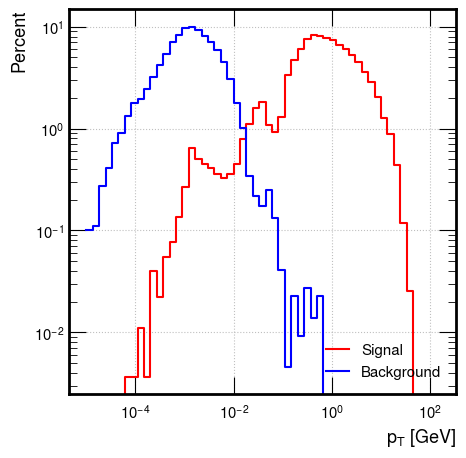

In [29]:
import seaborn as sns
bins = np.exp(np.arange(np.log(0.00001), np.log(150), 0.3))
plt.figure(figsize=(5,5))
signal = np.array(dic_signal["pt"])
# signal_v1 = np.array(dic_signal["pt"][dic_signal["count_hits"]>50])
background = np.array(dic_background["pt"])
# background_v1 = np.array(dic_background["p"][dic_background["count_hits"]>10])
sns.histplot(signal, stat="percent", element="step", fill=False, bins=bins, color="red", label="Signal")
sns.histplot(background, stat="percent", element="step", fill=False, bins=bins, color="blue", label="Background")
# sns.histplot(signal_v1, stat="percent", element="step", fill=False, bins=bins, color="green", label="Signal 10 hits")
# sns.histplot(background_v1, stat="percent", element="step", fill=False, bins=bins, color="yellow", label="Background 10 hits")
plt.xscale("log")
plt.xlabel("$p_T$ [GeV]")
plt.yscale("log")
plt.grid()
plt.legend()

In [8]:
import seaborn as sns
bins = np.exp(np.arange(np.log(0.00001), np.log(150), 1))
plt.figure(figsize=(5,5))
sns.histplot(dic_signal["p"], stat="density", element="step", fill=False)
sns.histplot(dic_background["p"], stat="density", element="step", fill=False)
plt.xscale("log")
plt.xlabel("p [Gev]")
plt.legend()

In [66]:
np.sqrt(dic_MC["y"]**2+dic_MC["x"]**2)

array([  0.        ,   0.        ,   0.        , ...,  23.20280816,
       -14.64642765,   0.16986936])

Text(1, 0, 'R [mm]')

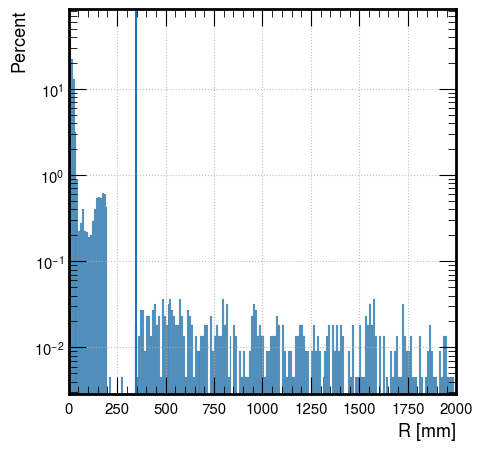

In [15]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(5, 5))
sns.histplot(np.sqrt(dic_MC["y"]**2+dic_MC["x"]**2), binwidth=10, stat="percent")
plt.xlim(0, 2000)
plt.axvline(x=349.8)
plt.grid()
plt.yscale("log")
plt.xlabel("R [mm]")

(-5.0, 2000.0)

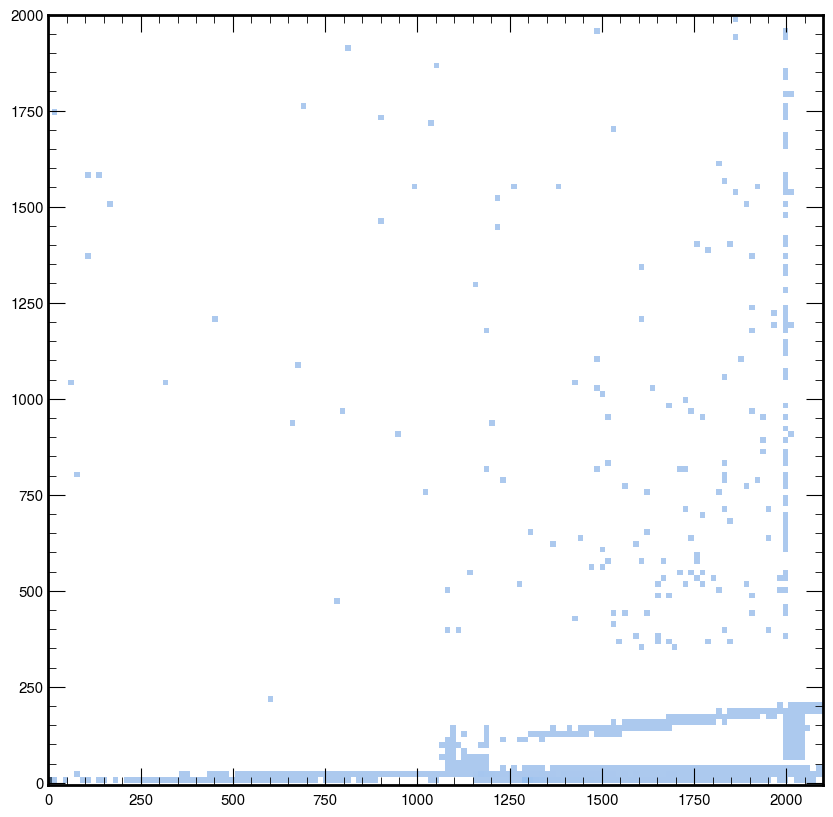

In [70]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 10))
sns.histplot( x=dic_MC["z"], y=np.sqrt(dic_MC["y"]**2+dic_MC["x"]**2), binwidth=15)
# plt.axvline(x=50)
# plt.axvline(x=-50)
# plt.axvline(x=140)
# plt.axvline(x=-140)
# plt.axvline(x=315)
# plt.axvline(x=-315)
# circle2 = plt.Circle((0, 0), 315+15, color='r', fill=False)
# ax.add_patch(circle2)
# circle2 = plt.Circle((0, 0), 349.8, color='g', fill=False)
# ax.add_patch(circle2)
# circle2 = plt.Circle((0, 0), 50, color='b', fill=False)
# ax.add_patch(circle2)
# circle2 = plt.Circle((0, 0), 140, color='r', fill=False) # <!-- R of the innermost layer of the outer vertex -->
# ax.add_patch(circle2)
plt.xlim(0, 2100)
plt.ylim(-5, 2000)

In [ ]:
dic_bp["p"].shape, dic_bp["count_hits"].shape

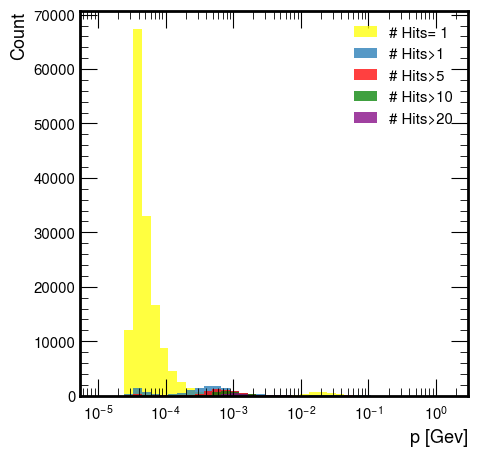

In [31]:
# for detector information check:
# https://indico.cern.ch/event/932973/contributions/4041314/attachments/2139657/3664808/primavera_FCCworkshop_2020.pdf
# The inner radius of the DC is at 35 cm 
import seaborn as sns
# plt.figure(figsize=(5,5))
# sns.histplot(dic_bp["R"]*1e3, stat="probability")
# plt.xlabel("vertex R [mm]")
bins = np.exp(np.arange(np.log(0.00001), np.log(2), 0.3))
plt.figure(figsize=(5,5))
sns.histplot(dic_bp["p"][dic_bp["count_hits"]==1], bins=bins, color="yellow", label="# Hits= 1")
mask_count_hits = dic_bp["count_hits"]>1
sns.histplot(dic_bp["p"][mask_count_hits], bins=bins, label="# Hits>1")
sns.histplot(dic_bp["p"][dic_bp["count_hits"]>5], bins=bins, color="red", label="# Hits>5")
sns.histplot(dic_bp["p"][dic_bp["count_hits"]>10], bins=bins, color="green", label="# Hits>10")
sns.histplot(dic_bp["p"][dic_bp["count_hits"]>20], bins=bins, color="purple", label="# Hits>20")
plt.xscale("log")
plt.xlabel("p [Gev]")
plt.legend()

In [32]:
np.unique(dic_bp["pdg"])
for i in np.unique(dic_bp["pdg"]):
    print(i, np.sum((dic_bp["pdg"]==i)*(dic_bp["count_hits"]==1)))

-211.0 6
-13.0 2
-11.0 67
11.0 147748
13.0 3
22.0 2
211.0 8
2112.0 2526
2212.0 423
1000010020.0 1
1000020040.0 183
1000060120.0 42


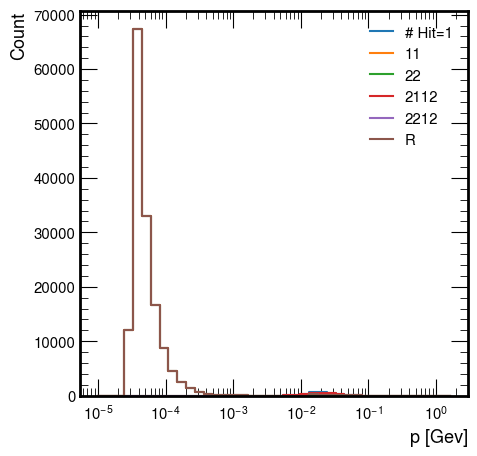

In [49]:
bins = np.exp(np.arange(np.log(0.00001), np.log(2), 0.3))
plt.figure(figsize=(5,5))
sns.histplot(dic_bp["p"][(dic_bp["count_hits"]==1)], bins=bins, label="# Hit=1", element="step", fill=False)
sns.histplot(dic_bp["p"][(dic_bp["count_hits"]==1)*((dic_bp["pdg"]==11)+(dic_bp["pdg"]==-11))], bins=bins, label="11", element="step", fill=False)
sns.histplot(dic_bp["p"][(dic_bp["count_hits"]==1)*((dic_bp["pdg"]==22))], bins=bins, label="22", element="step", fill=False)
sns.histplot(dic_bp["p"][(dic_bp["count_hits"]==1)*((dic_bp["pdg"]==2112))], bins=bins, label="2112", element="step", fill=False)
sns.histplot(dic_bp["p"][(dic_bp["count_hits"]==1)*((dic_bp["pdg"]==2212))], bins=bins, label="2212", element="step", fill=False)
sns.histplot(dic_bp["p"][(dic_bp["R"]>0.3)*(dic_bp["count_hits"]==1)], bins=bins, label="R", element="step", fill=False)
plt.xscale("log")
plt.xlabel("p [Gev]")
plt.legend()

<Axes: ylabel='Count'>

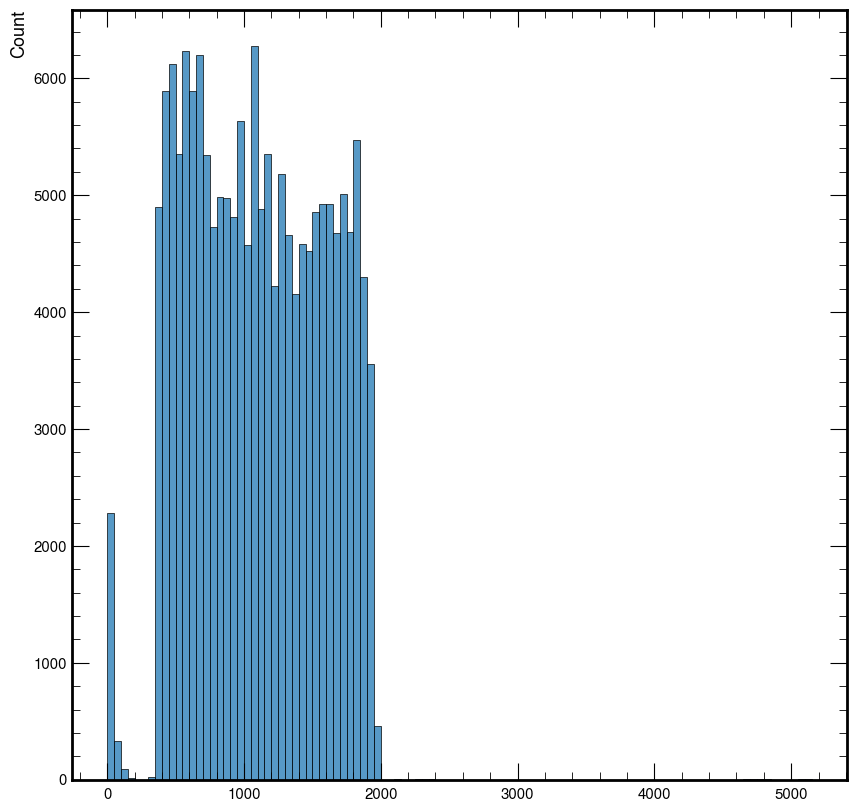

In [46]:
sns.histplot(dic_bp["R"]*1e3, binwidth=50)

In [1]:
bins = np.exp(np.arange(np.log(0.00001), np.log(2), 0.3))
plt.figure(figsize=(5,5))
sns.histplot(dic_bp["p"][(dic_bp["count_hits"]>1)], bins=bins, label="# Hit=1", element="step", fill=False)
sns.histplot(dic_bp["p"][(dic_bp["count_hits"]>1)*((dic_bp["pdg"]==11)+(dic_bp["pdg"]==-11))], bins=bins, label="11", element="step", fill=False)
sns.histplot(dic_bp["p"][(dic_bp["count_hits"]>1)*((dic_bp["pdg"]==22))], bins=bins, label="22", element="step", fill=False)
sns.histplot(dic_bp["p"][(dic_bp["count_hits"]>1)*((dic_bp["pdg"]==2112))], bins=bins, label="2112", element="step", fill=False)
sns.histplot(dic_bp["p"][(dic_bp["count_hits"]>1)*((dic_bp["pdg"]==2212))], bins=bins, label="2212", element="step", fill=False)
sns.histplot(dic_bp["p"][(dic_bp["R"]>1)*(dic_bp["count_hits"]>1)], bins=bins, label="R", element="step", fill=False)

plt.xscale("log")
plt.xlabel("p [Gev]")
plt.legend()

NameError: name 'np' is not defined

In [25]:
# particles created in the DC:
mask_particles_created_inDC = (dic_bp["R"]*1e3)>350
dic_bp["pz"][mask_particles_created_inDC]

array([ 1.76349844e-05, -2.75046535e-05, -2.34247570e-06,  9.33655934e-06,
        4.35294251e-06,  5.07040180e-05,  1.73440089e-05, -3.02105275e-05,
       -2.44239708e-05,  9.12673269e-06, -3.38008520e-05, -2.31907944e-05,
        5.55875213e-05, -7.68003403e-05, -3.13499563e-05,  3.08449961e-05,
        2.19508587e-05, -4.65870281e-06, -4.93083698e-05,  2.30518776e-05,
       -2.61237519e-05,  2.71996704e-05, -2.03673709e-05,  6.51679946e-05,
        1.59619529e-05, -2.07701025e-05,  1.56571080e-05,  2.81067997e-05,
        3.71708999e-06,  4.51028038e-06, -4.99695386e-05, -3.07126221e-05,
       -5.06804090e-05,  2.18179143e-05, -2.88494916e-05,  3.66881479e-05,
       -1.26736964e-04, -1.24899426e-05,  1.36359361e-05,  1.41093488e-05,
        1.78644601e-05, -6.38479416e-06, -2.16408191e-06,  1.33908190e-05,
       -1.02063250e-05, -7.39628409e-07, -1.98488756e-05,  7.97594726e-04,
        9.46153894e-03, -8.97216322e-04,  7.63348344e-06,  6.78852029e-07,
        1.78252210e-06,  

/eos/experiment/fcc/ee/datasets/DC_tracking/Pythia/gun_fakeCalo_g1/reco_gun_1000.root